# Testing the creation of a 'xr_phenology' function

Random online python phenology functions that might help:

- https://gist.github.com/YanCheng-go/d4e17831f294199443d0f7682558e608

- https://github.com/JavierLopatin/PhenoPY


In [ ]:
# !pip install kneed
# !pip install KDEpy
# !pip install jdcal
# !pip install lmfit

### Load modules

In [77]:
import sys
import os
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import warnings
# import phenopy as phen
import pandas as pd
# from phen_test import pheno_map
import deafrica_phenology
sys.path.append('../Scripts')
from deafrica_plotting import display_map, rgb
from deafrica_datahandling import mostcommon_crs, load_ard
from deafrica_bandindices import calculate_indices

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load some data to work with

In [2]:
dc = datacube.Datacube(app='phenology stats')

In [3]:
# lat = -10.6976
# lon = 35.2708
# lon_buffer = 0.00200
# lat_buffer = 0.00190

lat = 30.2522
lon = 30.5516
buffer = 0.003

x = (lon - buffer, lon + buffer)
y =  (lat + buffer, lat - buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2018'),
    'resolution': (-20, 20)
}

In [5]:
# display_map(x=x, y=y)

In [79]:
#find the most common UTM crs for the location
output_crs = mostcommon_crs(dc=dc, product='usgs_ls8c_level2_2', query=query)

# Load available data
ds = load_ard(dc=dc, 
              products=['usgs_ls8c_level2_2'],
              measurements=['green','red','blue','nir'],
              group_by='solar_day',
              min_gooddata=0.5,
              output_crs=output_crs, 
              **query)

# Print output data
print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    usgs_ls8c_level2_2
Counting good quality pixels for each time step
Filtering to 21 out of 23 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 21 time steps
<xarray.Dataset>
Dimensions:      (time: 21, x: 30, y: 35)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-12T08:30:07.070431 ... 2018-12-30T08:29:55.020399
    spatial_ref  int32 0
  * y            (y) float64 3.35e+06 3.35e+06 3.35e+06 ... 3.349e+06 3.349e+06
  * x            (x) float64 2.641e+05 2.642e+05 ... 2.647e+05 2.647e+05
Data variables:
    green        (time, y, x) float32 13057.0 12053.0 ... 10341.0 13909.0
    red          (time, y, x) float32 14122.0 12337.0 11350.0 ... 9947.0 15328.0
    blue         (time, y, x) float32 10837.0 10054.0 9464.0 ... 8789.0 10981.0
    nir          (time, y, x) float32 18096.0 20122.0 ... 22336.0 21601.0
Attributes:
    crs:           epsg:32636
    grid_map

### Calculate NDVI and DOY

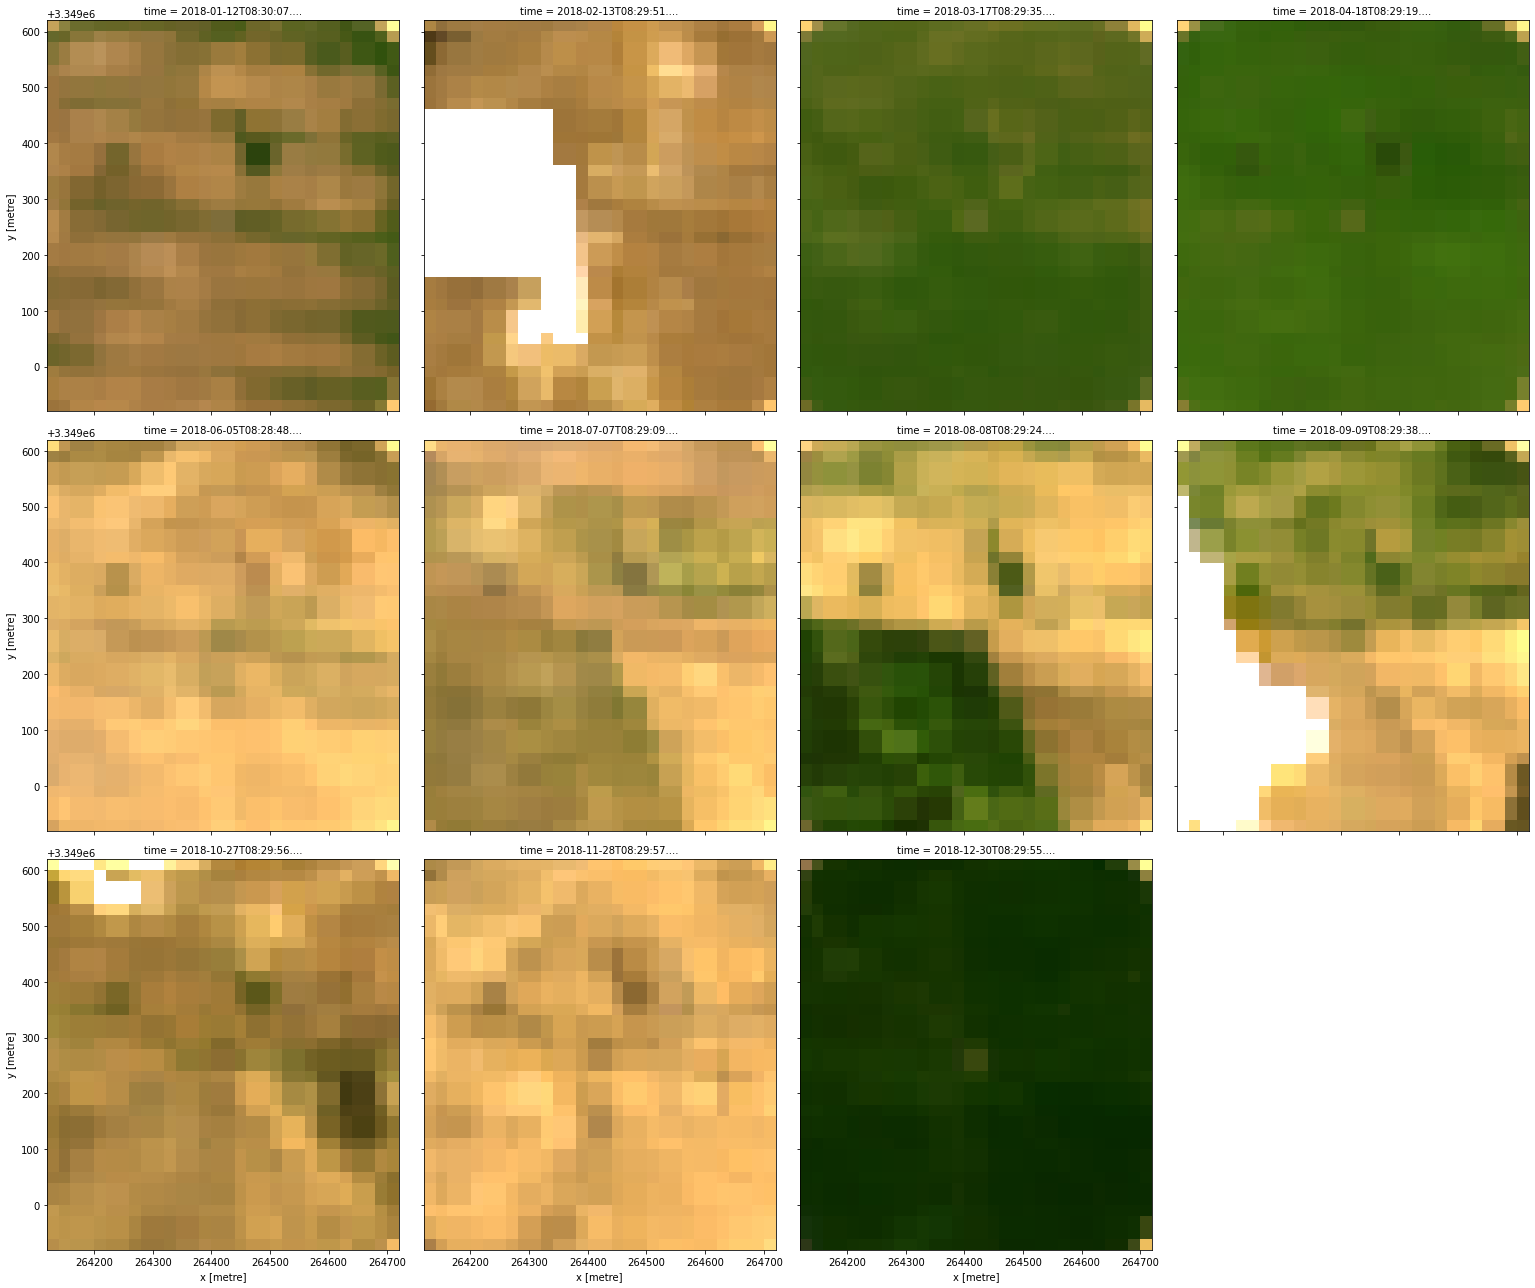

In [84]:
rgb(ds, index=[0,2,4,6,8,10,12,14,16,18,20])

In [34]:
# First we calculate NDVI on each image in the timeseries
ndvi = calculate_indices(ds, index='NDVI', collection='s2', drop=True)
doy=ndvi.time.dt.dayofyear

Dropping bands ['red', 'nir']


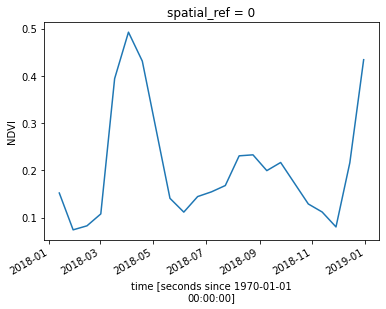

In [35]:
ndvi.NDVI.mean(['x','y']).plot()

### Test each statistic

After confirming each statistic is working, then adding the code to the `deafrica_phenology.py` script.

Statistics to calculate:

    SOS = DOY of start of season
    POS = DOY of peak of season
    EOS = DOY of end of season
    vSOS = Value at start of season
    vPOS = Value at peak of season
    vEOS = Value at end of season
    LOS = Length of season (DOY)
    AOS = Amplitude of season (in value units)
    IOS = Integral of season (SOS-EOS)
    ROG = Rate of greening
    ROS = Rate of senescence
    SW = Skewness of growing season


Statistics that are working:

In [86]:
vpos=deafrica_phenology._vpos(ndvi.NDVI)
pos = deafrica_phenology._pos(ndvi.NDVI)
trough = deafrica_phenology._trough(ndvi.NDVI)
aos =deafrica_phenology._aos(vpos, trough)
ratio = deafrica_phenology._ratio(ndvi.NDVI, trough, aos)

Statistics in progress:

In [95]:
#working on SOS
fst_deriv = ratio.differentiate('time')
pos_fst_deriv = fst_deriv > 0
neg_fst_deriv = 0 > fst_deriv
snd_deriv = fst_deriv.differentiate('time')
pos_snd_deriv = snd_deriv > 0
neg_snd_deriv = 0 > snd_deriv

#### This works...but only for 1D arrays. Could be good if used after zonal-stats are calculated

In [28]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.integrate import trapz
from scipy.stats import skew
# from deafrica_phenology import PhenologyMetrics


In [29]:
def _getPhenologyMetrics(da, doy):
    
    """
    Obtain land surfurface phenology metrics
    Parameters
    ----------
    - da:  xr.Datarray
    - doy: xt.DataArray
        Dayofyer values for each time step in the 'time'
        dim on 'da'. e.g doy=da.time.dt.dayofyear
    Outputs
    -------
        SOS = DOY of start of season
        POS = DOY of peak of season
        EOS = DOY of end of season
        vSOS = Value at start of season
        vPOS = Value at peak of season
        vEOS = Value at end of season
        LOS = Length of season (DOY)
        AOS = Amplitude of season (in value units)
        IOS = Integral of season (SOS-EOS)
        ROG = Rate of greening
        ROS = Rate of senescence
        SW = Skewness of growing season
    """
    stats=[]
    
    # basic variables
    vpos = np.nanmax(da)
    ipos = np.where(da == vpos)[0]
    print(ipos)
    pos = doy[ipos]
    trough = np.nanmin(da)
    ampl = vpos - trough

    # get position of seasonal peak and trough
    ipos = np.where(da == vpos)

    # scale annual time series to 0-1
    ratio = (da - trough) / ampl

    # separate greening from senesence values
    dev = np.gradient(ratio)  # first derivative
    greenup = np.zeros([ratio.shape[0]],  dtype=bool)
    greenup[dev > 0] = True

    # estimate SOS and EOS as median of the seasons
    i = np.nanmedian(doy[:ipos[0][0]][greenup[:ipos[0][0]]])
    ii = np.nanmedian(doy[ipos[0][0]:][~greenup[ipos[0][0]:]])
    sos = doy[(np.abs(doy - i)).argmin()]
    eos = doy[(np.abs(doy - ii)).argmin()]
    isos = np.where(doy == int(sos))[0]
    ieos = np.where(doy == eos)[0]
    if sos is None:
        isos = 0
        sos = doy[isos]
    if eos is None:
        ieos = len(doy) - 1
        eos = doy[ieos]

    # los: length of season
    los = eos - sos
    if los < 0:
        los[los < 0] = len(da) + \
            (eos[los < 0] - sos[los < 0])

    # doy of growing season
    green = doy[(doy > sos) & (doy < eos)]
    _id = []
    for i in range(len(green)):
        _id.append((doy == green[i]).nonzero()[0])

    # index of growing season
    _id = np.array([item for sublist in _id for item in sublist])
    # get intergral of green season
    ios = trapz(da[_id], doy[_id])

    # rate of greening [slope SOS-POS]
    rog = (vpos - da[isos]) / (pos - sos)
    rog = rog[0]

    # rate of senescence [slope POS-EOS]
    ros = (da[ieos] - vpos) / (eos - pos)
    ros= ros[0]

    # skewness of growing season
    sw = skew(da[_id])

    #values at start of season
    vsos = da[isos][0]

    #values at end of season
    veos = da[ieos][0]
    
    print(sos,pos[0],eos, vsos, vpos, veos, los, ampl, ios, rog, ros, sw)

    #return metrics
        

In [30]:
#create fake data
ndvi = np.array([0,0.0,0.2, 0.5, 0.9, 0.9, 0.9, 0.8, 0.75, 0.1, 0.0, 0.0])
test_da = xr.DataArray(ndvi,
             coords=[pd.date_range("01/01/2018", periods=12, freq=pd.DateOffset(months=1),)],dims="time")

doy=test_da.time.dt.dayofyear

In [31]:
xr.apply_ufunc(
        _getPhenologyMetrics,
        test_da,
        input_core_dims=[["time"]],
        kwargs={'doy': doy.values},
        dask='allowed')

[4 5 6]
60 121 244 0.2 0.9 0.75 184 0.9 102.25 0.011475409836065573 -0.0012195121951219514 -1.290994448735806


<xarray.DataArray ()>
array(None, dtype=object)

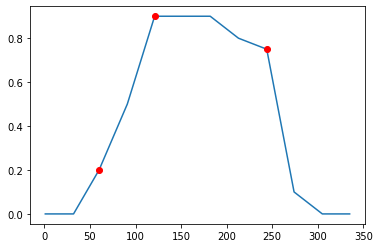

In [32]:
ax = plt.subplot(1, 1, 1)
ax.plot(doy, ndvi)
ax.plot(60,0.2, "or")
ax.plot(244,0.75, "or")
ax.plot(121, 0.9, "or")

In [1]:
def TIMESAT_stats(da, doy):
   
    #empty dict to put results in
    stats = {}
    
    data_np_arr = da
    time_np_arr = doy
    data_inds = np.arange(len(data_np_arr))
    
    # Obtain the first and second derivatives.
    fst_deriv = np.gradient(data_np_arr, time_np_arr)
    pos_fst_deriv = fst_deriv > 0
    neg_fst_deriv = 0 > fst_deriv
    snd_deriv = np.gradient(fst_deriv, time_np_arr)
    pos_snd_deriv = snd_deriv > 0
    neg_snd_deriv = 0 > snd_deriv
    
    # Determine MOS.
    # MOS is the index of the highest value immediately preceding a transition
    # of the first derivative from positive to negative.
    pos_to_neg_fst_deriv = pos_fst_deriv.copy()
    for i in range(len(pos_fst_deriv)):
        if i == len(pos_fst_deriv) - 1: # last index
            pos_to_neg_fst_deriv[i] = False
        elif pos_fst_deriv[i] and not pos_fst_deriv[i+1]: # + to -
            pos_to_neg_fst_deriv[i] = True
        else: # everything else
            pos_to_neg_fst_deriv[i] = False
    idxmos_potential_inds = data_inds[pos_to_neg_fst_deriv]
    idxmos_subset_ind = np.argmax(data_np_arr[pos_to_neg_fst_deriv])
    idxmos = idxmos_potential_inds[idxmos_subset_ind]
    stats['Middle of Season'] = idxmos
    
    data_inds_after_mos = np.roll(data_inds, len(data_inds)-idxmos-1)
    
    # Determine BOS.
    # BOS is the first negative inflection point of the positive values 
    # of the first derivative starting after and ending at the MOS.
    idxbos = data_inds_after_mos[np.argmax((pos_fst_deriv & neg_snd_deriv)[data_inds_after_mos])]
    stats['Beginning of Season'] = idxbos
    
    # Determine EOS.
    # EOS is the last positive inflection point of the negative values 
    # of the first derivative starting after and ending at the MOS.
    idxeos = data_inds_after_mos[np.argmax((neg_fst_deriv & pos_snd_deriv)[data_inds_after_mos][::-1])]
    stats['End of Season'] = idxeos
    
    # Determine EOS-BOS.
    stats['Length of Season'] = idxeos - idxbos
    # Determine BASE.
    stats['Base Value'] = np.nanmin(data_np_arr)
    # Determine MAX.
    stats['Max Value'] = np.nanmax(data_np_arr)
    # Determine AMP.
    stats['Amplitude'] = stats['Max Value'] - stats['Base Value']
    
    #Rate of greening [slope StartOS-PeakOS]
    da[idxmos] - da[idxbos / 
    
    print(stats)
    return stats

SyntaxError: invalid syntax (<ipython-input-1-959e9c2b4f13>, line 61)